In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [32]:
df = pd.read_csv('merged_flight_weather_data.csv')

In [33]:
df

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,dewpoint_f,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,uv
0,2023-07-03,JetBlue Airways,JetBlue Airways: B6,B6,20409,431,BOS,"Boston, MA",LGA,"New York, NY",...,68.1,0,0,0,0,10.0,6,13.2,21.2,2.7
1,2020-02-26,JetBlue Airways,JetBlue Airways: B6,B6,20409,965,BOS,"Boston, MA",RSW,"Fort Myers, FL",...,43.0,0,0,0,0,8.3,5,18.8,30.2,0.0
2,2020-10-13,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1621,BOS,"Boston, MA",MDW,"Chicago, IL",...,51.8,1,100,0,0,7.0,4,22.6,36.4,0.0
3,2022-12-03,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2600,BOS,"Boston, MA",DFW,"Dallas/Fort Worth, TX",...,45.6,0,0,0,0,10.0,6,28.6,46.0,0.0
4,2023-01-17,JetBlue Airways,JetBlue Airways: B6,B6,20409,781,BOS,"Boston, MA",RIC,"Richmond, VA",...,16.3,0,0,0,0,10.0,6,11.3,18.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55389,2021-10-01,Republic Airline,Republic Airline: YX,YX,20452,5632,BOS,"Boston, MA",JFK,"New York, NY",...,39.1,0,0,0,0,10.0,6,11.2,18.0,0.0
55390,2019-03-27,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,688,BOS,"Boston, MA",PHL,"Philadelphia, PA",...,12.7,0,0,0,0,10.0,6,13.8,22.3,0.1
55391,2023-04-26,JetBlue Airways,JetBlue Airways: B6,B6,20409,2301,BOS,"Boston, MA",MSY,"New Orleans, LA",...,39.5,0,0,0,0,10.0,6,14.6,23.5,7.0
55392,2023-07-09,Republic Airline,Republic Airline: YX,YX,20452,4296,BOS,"Boston, MA",JFK,"New York, NY",...,68.5,0,0,0,0,10.0,6,14.0,22.5,1.3


In [34]:

# --- Data Cleaning ---
# Cancelled flights: force DEPTIME as NaN
if 'CANCELLED' in df and 'DEPTIME' in df:
    df.loc[df['CANCELLED'] == 1, 'DEPTIME'] = np.nan

# Fill missing values: numeric 0, text 'Null'
for c in df.columns:
    if pd.api.types.is_numeric_dtype(df[c]):
        df[c] = df[c].fillna(0)
    else:
        df[c] = df[c].fillna('Null')

# Quality: print missing counts
print(df.isnull().sum())

FL_DATE         0
AIRLINE         0
AIRLINE_DOT     0
AIRLINE_CODE    0
DOT_CODE        0
               ..
vis_km          0
vis_miles       0
gust_mph        0
gust_kph        0
uv              0
Length: 70, dtype: int64


In [38]:
# 1. Define on-time vs delayed and inspect distribution
delay_threshold = 15  # minutes
df['ONTIME'] = np.where(df['DEP_DELAY'] <= delay_threshold, 1, 0)  # 1=on-time, 0=delayed

print("DEP_DELAY summary:")
print(df['DEP_DELAY'].describe())
print("\nONTIME value counts:")
print(df['ONTIME'].value_counts())
print("\nONTIME value proportion:")
print(df['ONTIME'].value_counts(normalize=True))


DEP_DELAY summary:
count    55394.000000
mean        10.872369
std         48.415003
min        -41.000000
25%         -6.000000
50%         -3.000000
75%          5.000000
max       1481.000000
Name: DEP_DELAY, dtype: float64

ONTIME value counts:
ONTIME
1    45579
0     9815
Name: count, dtype: int64

ONTIME value proportion:
ONTIME
1    0.822815
0    0.177185
Name: proportion, dtype: float64


In [39]:
# --- Feature Engineering ---
# Round flight time to nearest hour for grouping
if 'DEPTIME' in df and not df['DEPTIME'].isnull().all():
    df['DEPHOUR'] = (df['DEPTIME'] // 100 + (df['DEPTIME'] % 100 >= 30)).astype('Int64')
else:
    df['DEPHOUR'] = pd.NA


# 2. Feature engineering

# Departure hour from scheduled departure time (CRS_DEP_TIME in HHMM)
df['DEP_HOUR'] = (df['CRS_DEP_TIME'] // 100).astype(int)

# Day of week and month from FL_DATE
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek  # 0=Mon
df['MONTH'] = df['FL_DATE'].dt.month

# Airport congestion: number of departures in the same hour at BOS
df['DEP_HOUR_KEY'] = df['FL_DATE'].dt.date.astype(str) + "_" + df['DEP_HOUR'].astype(str)
df['HOURLY_DEP_COUNT'] = df.groupby('DEP_HOUR_KEY')['DEP_DELAY'].transform('count')

# Time-of-day as cyclical features (makes more sense than raw time_epoch)
df['HOUR_SIN'] = np.sin(2 * np.pi * df['DEP_HOUR'] / 24)
df['HOUR_COS'] = np.cos(2 * np.pi * df['DEP_HOUR'] / 24)

# Choose key numeric features
numeric_features = [
    'DEP_HOUR', 'DAY_OF_WEEK', 'MONTH', 'HOURLY_DEP_COUNT',
    'wind_mph', 'wind_kph', 'humidity', 'vis_km', 'vis_miles',
    'precip_mm', 'temp_c', 'temp_f'
]
numeric_features = [c for c in numeric_features if c in df.columns]

# One-hot encode airline
df_model = df.copy()
if 'AIRLINE' in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=['AIRLINE'], drop_first=True)

airline_cols = [c for c in df_model.columns if c.startswith('AIRLINE_')]

feature_cols = numeric_features + airline_cols
print("Number of features used:", len(feature_cols))


# --- Plots: Weather vs Delay ---
plot_vars = ['windmph', 'precipmm', 'humidity', 'viskm', 'winddegree']
for var in plot_vars:
    if var in df.columns:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=var, y='DEP_DELAY', data=df)
        plt.title(f'{var} vs Departure Delay')
        plt.tight_layout()
        plt.savefig(f'{var}_vs_delay.png')
        plt.close()

# Histogram: Departure delay
plt.figure(figsize=(8, 5))
sns.histplot(df['DEP_DELAY'], bins=30)
plt.title('Distribution of Departure Delay (min)')
plt.tight_layout()
plt.savefig('delay_histogram.png')
plt.close()

# Boxplot: By hour and by airline
plt.figure(figsize=(12, 6))
sns.boxplot(x='DEP_HOUR', y='DEP_DELAY', data=df)
plt.title('Delay by Departure Hour')
plt.tight_layout()
plt.savefig('box_by_hour.png')
plt.close()


Number of features used: 30


In [54]:
if 'AIRLINE' in df.columns:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='AIRLINE', y='DEP_DELAY', data=df)
    plt.title('Departure Delay by Airline')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('box_by_airline.png')
    plt.close()

# --- On-time Classification ---
df['ONTIME'] = np.where(df['DEP_DELAY'] <= 15, 1, 0)
plt.figure(figsize=(6,4))
sns.countplot(x='ONTIME', data=df)
plt.title('On-Time vs Delayed')
plt.tight_layout()
plt.savefig('on_time_vs_delayed.png')
plt.close()


In [55]:
# 3. Build X, y for regression and classification
X = df_model[feature_cols].select_dtypes(include=['int64', 'float64'])
y_reg = df_model['DEP_DELAY']
y_clf = df_model['ONTIME']

print("X shape:", X.shape)
print("Regression target mean/std:", y_reg.mean(), y_reg.std())
print("Classification ONTIME proportions:\n", y_clf.value_counts(normalize=True))


X shape: (55394, 10)
Regression target mean/std: 10.872368848611764 48.41500307032798
Classification ONTIME proportions:
 ONTIME
1    0.822815
0    0.177185
Name: proportion, dtype: float64


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.633e+07, tolerance: 1.063e+04
  model = cd_fast.enet_coordinate_descent(


              Model        R2       RMSE        MAE
5  GradientBoosting  0.069145  44.458777  21.808340
4      RandomForest  0.050305  44.906434  21.694691
0  LinearRegression  0.035430  45.256735  22.293599
1             Ridge  0.035407  45.257281  22.293511
2             Lasso  0.035251  45.260932  22.293738
3        ElasticNet  0.035241  45.261178  22.293927

Top features by absolute LR coefficient:
temp_c              7.792868
temp_f              4.402154
vis_miles           2.142767
precip_mm           1.985785
DEP_HOUR            1.423685
wind_mph            0.895814
HOURLY_DEP_COUNT    0.865375
vis_km              0.660105
wind_kph            0.302493
humidity            0.161436
dtype: float64
GB 5-fold CV RMSE: 6.86786890417635


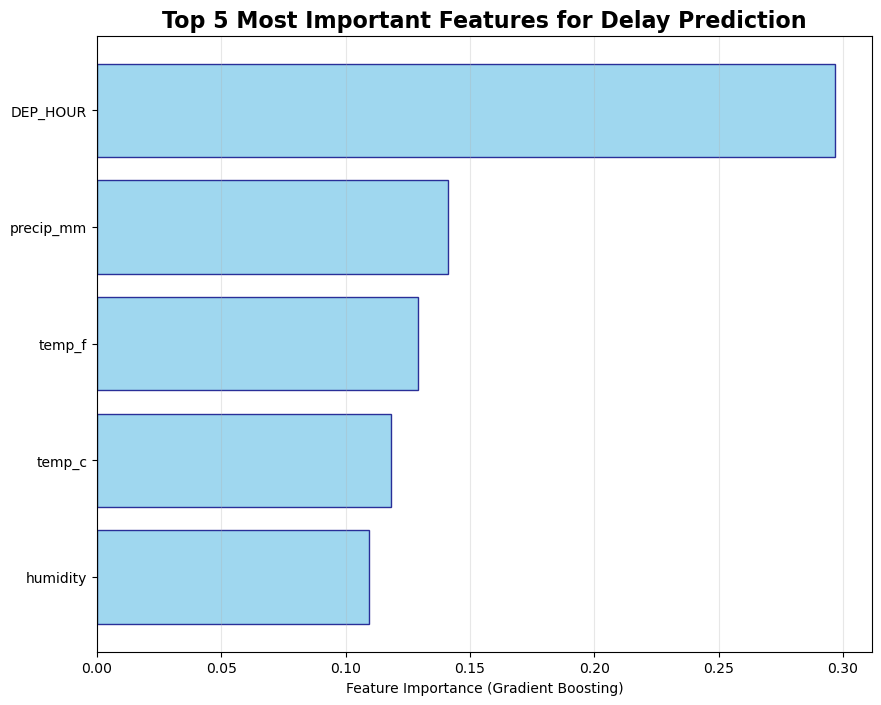

In [56]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

reg_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=5.0),
    'Lasso': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
    'RandomForest': RandomForestRegressor(
        n_estimators=200, max_depth=12, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42)
}

reg_results = []
for name, model in reg_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    reg_results.append([name, r2, rmse, mae])

reg_results_df = pd.DataFrame(reg_results, columns=['Model', 'R2', 'RMSE', 'MAE'])
print(reg_results_df.sort_values('R2', ascending=False))

lr = LinearRegression().fit(X_train, y_train)
imp_features = pd.Series(lr.coef_, index=X.columns).abs().sort_values(ascending=False)
print("\nTop features by absolute LR coefficient:")
print(imp_features.head(20))

# K-fold CV for best model (example: GradientBoosting)
best_reg = reg_models['GradientBoosting']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_reg, X, y_reg, cv=kf, scoring='neg_root_mean_squared_error')
print("GB 5-fold CV RMSE:", np.sqrt(-cv_scores).mean())
# Feature importance plot for best model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_reg.feature_importances_
}).sort_values('importance', ascending=True).tail(5)

plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(feature_importance)), feature_importance['importance'],


                color='skyblue', edgecolor='navy', alpha=0.8)
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance (Gradient Boosting)')
plt.title('Top 5 Most Important Features for Delay Prediction', fontsize=16, fontweight
='bold')
plt.grid(axis='x', alpha=0.3)


In [57]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("Class distribution in train:")
print(yc_train.value_counts(normalize=True))

# SMOTE oversampling on training data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(Xc_train, yc_train)

print("After SMOTE:")
print(y_res.value_counts(normalize=True))

# Models with class weights / suitable for imbalance
clf_models = {
    'LogisticRegression_balanced': LogisticRegression(
        max_iter=500, class_weight='balanced'),
    'SVM_rbf_balanced': SVC(kernel='rbf', probability=True, class_weight='balanced'),
    'KNN_5': KNeighborsClassifier(n_neighbors=5)
}

clf_results = []
for name, clf in clf_models.items():
    clf.fit(X_res, y_res)
    y_pred = clf.predict(Xc_test)
    y_proba = clf.predict_proba(Xc_test)[:, 1] if hasattr(clf, "predict_proba") else None

    acc = accuracy_score(yc_test, y_pred)
    prec = precision_score(yc_test, y_pred)
    rec = recall_score(yc_test, y_pred)
    f1 = f1_score(yc_test, y_pred)

    print(f"\n=== {name} ===")
    print("Confusion matrix:\n", confusion_matrix(yc_test, y_pred))
    print("Classification report:\n", classification_report(yc_test, y_pred, digits=3))
    clf_results.append([name, acc, prec, rec, f1])

clf_results_df = pd.DataFrame(
    clf_results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
print(clf_results_df.sort_values('F1', ascending=False))


Class distribution in train:
ONTIME
1    0.822814
0    0.177186
Name: proportion, dtype: float64
After SMOTE:
ONTIME
0    0.5
1    0.5
Name: proportion, dtype: float64

=== LogisticRegression_balanced ===
Confusion matrix:
 [[1136  827]
 [3461 5655]]
Classification report:
               precision    recall  f1-score   support

           0      0.247     0.579     0.346      1963
           1      0.872     0.620     0.725      9116

    accuracy                          0.613     11079
   macro avg      0.560     0.600     0.536     11079
weighted avg      0.762     0.613     0.658     11079


=== SVM_rbf_balanced ===
Confusion matrix:
 [[1166  797]
 [3245 5871]]
Classification report:
               precision    recall  f1-score   support

           0      0.264     0.594     0.366      1963
           1      0.880     0.644     0.744      9116

    accuracy                          0.635     11079
   macro avg      0.572     0.619     0.555     11079
weighted avg      0.771     0.

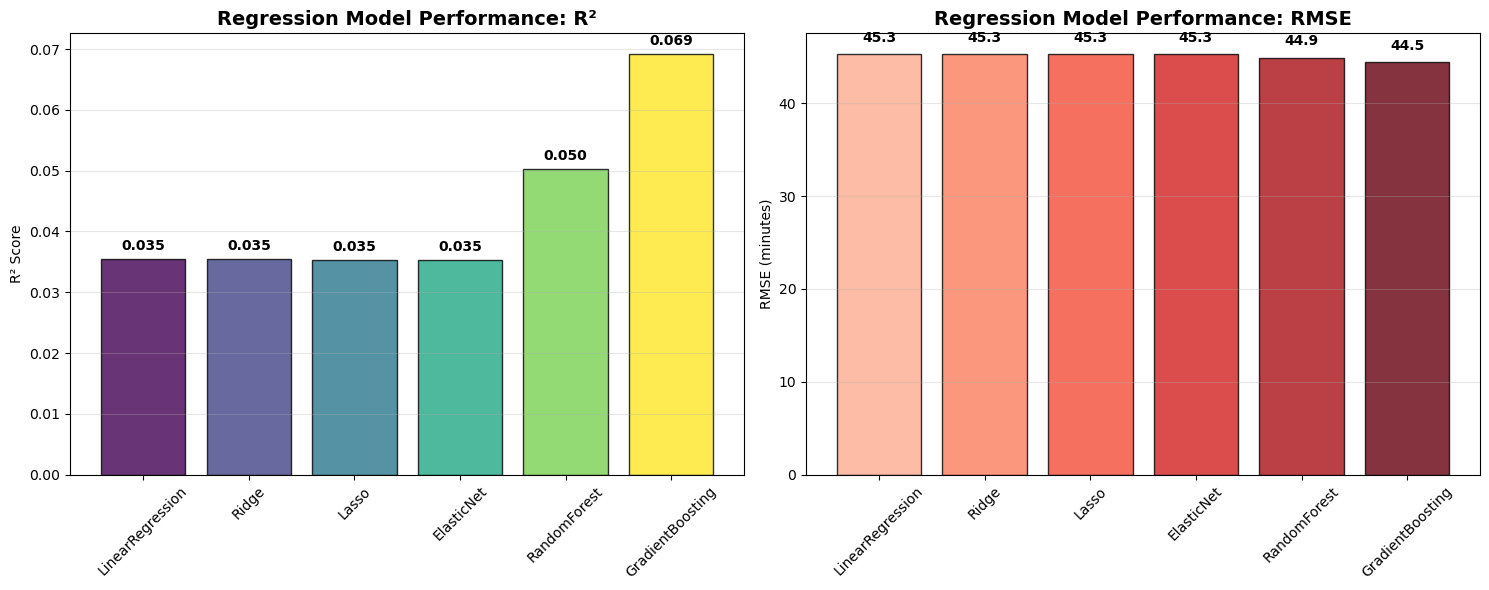

**Key Insight:** Gradient Boosting achieves highest R² while maintaining reasonable RMSE.


In [43]:
# Regression model comparison - Professional bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# R² comparison
colors_r2 = plt.cm.viridis(np.linspace(0, 1, len(reg_results_df)))
bars1 = ax1.bar(reg_results_df['Model'], reg_results_df['R2'], color=colors_r2, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Regression Model Performance: R²', fontsize=14, fontweight='bold')
ax1.set_ylabel('R² Score')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, r2 in zip(bars1, reg_results_df['R2']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

# RMSE comparison
colors_rmse = plt.cm.Reds(np.linspace(0.3, 1, len(reg_results_df)))
bars2 = ax2.bar(reg_results_df['Model'], reg_results_df['RMSE'], color=colors_rmse, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('Regression Model Performance: RMSE', fontsize=14, fontweight='bold')
ax2.set_ylabel('RMSE (minutes)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rmse in zip(bars2, reg_results_df['RMSE']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{rmse:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('regression_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("**Key Insight:** Gradient Boosting achieves highest R² while maintaining reasonable RMSE.")


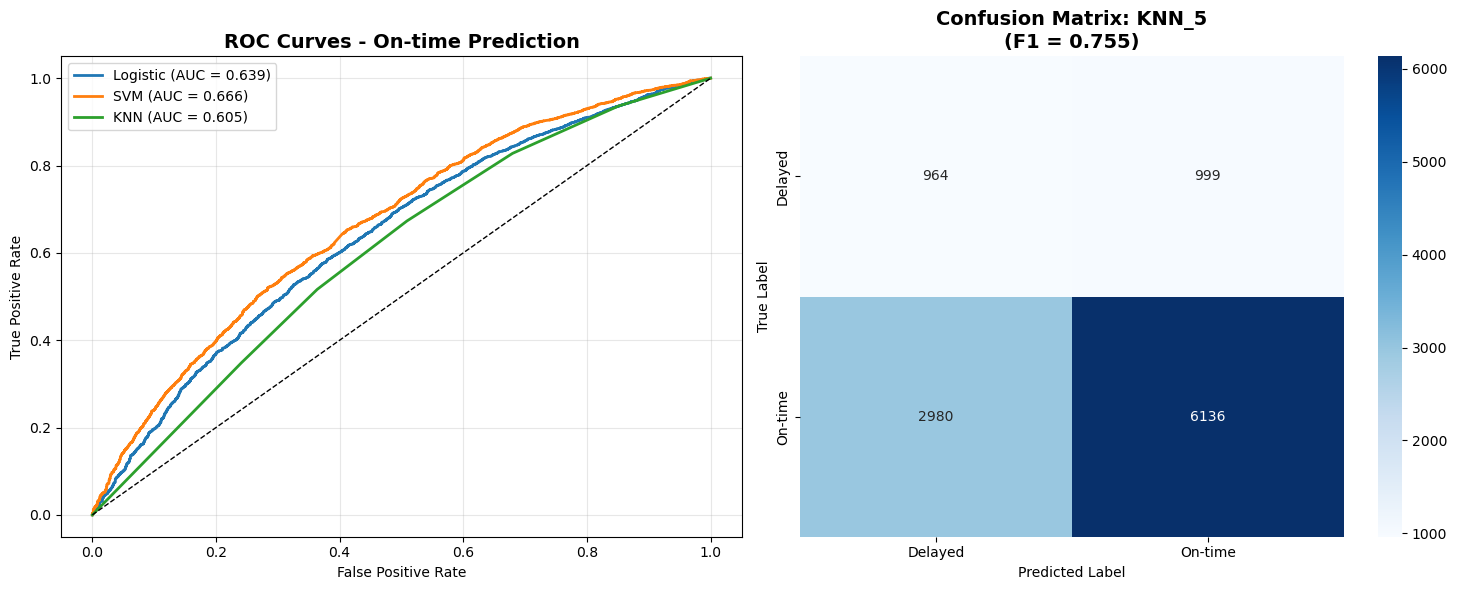

In [45]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# ROC Curves for probabilistic models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC for Logistic and SVM
for name, clf in [('Logistic', clf_models['LogisticRegression_balanced']), 
                  ('SVM', clf_models['SVM_rbf_balanced']),
                  ('KNN', clf_models['KNN_5'])]:
    if hasattr(clf, 'predict_proba'):
        y_proba = clf.predict_proba(Xc_test)[:, 1]
        fpr, tpr, _ = roc_curve(yc_test, y_proba)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - On-time Prediction', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Confusion Matrix Heatmap for best model
best_clf_name = clf_results_df.loc[clf_results_df['F1'].idxmax(), 'Model']
best_clf = clf_models[best_clf_name.replace('balanced', '_balanced')] if 'balanced' in best_clf_name else clf_models[best_clf_name]

cm = confusion_matrix(yc_test, best_clf.predict(Xc_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Delayed', 'On-time'], yticklabels=['Delayed', 'On-time'])
ax2.set_title(f'Confusion Matrix: {best_clf_name}\n(F1 = {clf_results_df["F1"].max():.3f})', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('classification_performance.png', dpi=300, bbox_inches='tight')
plt.show()


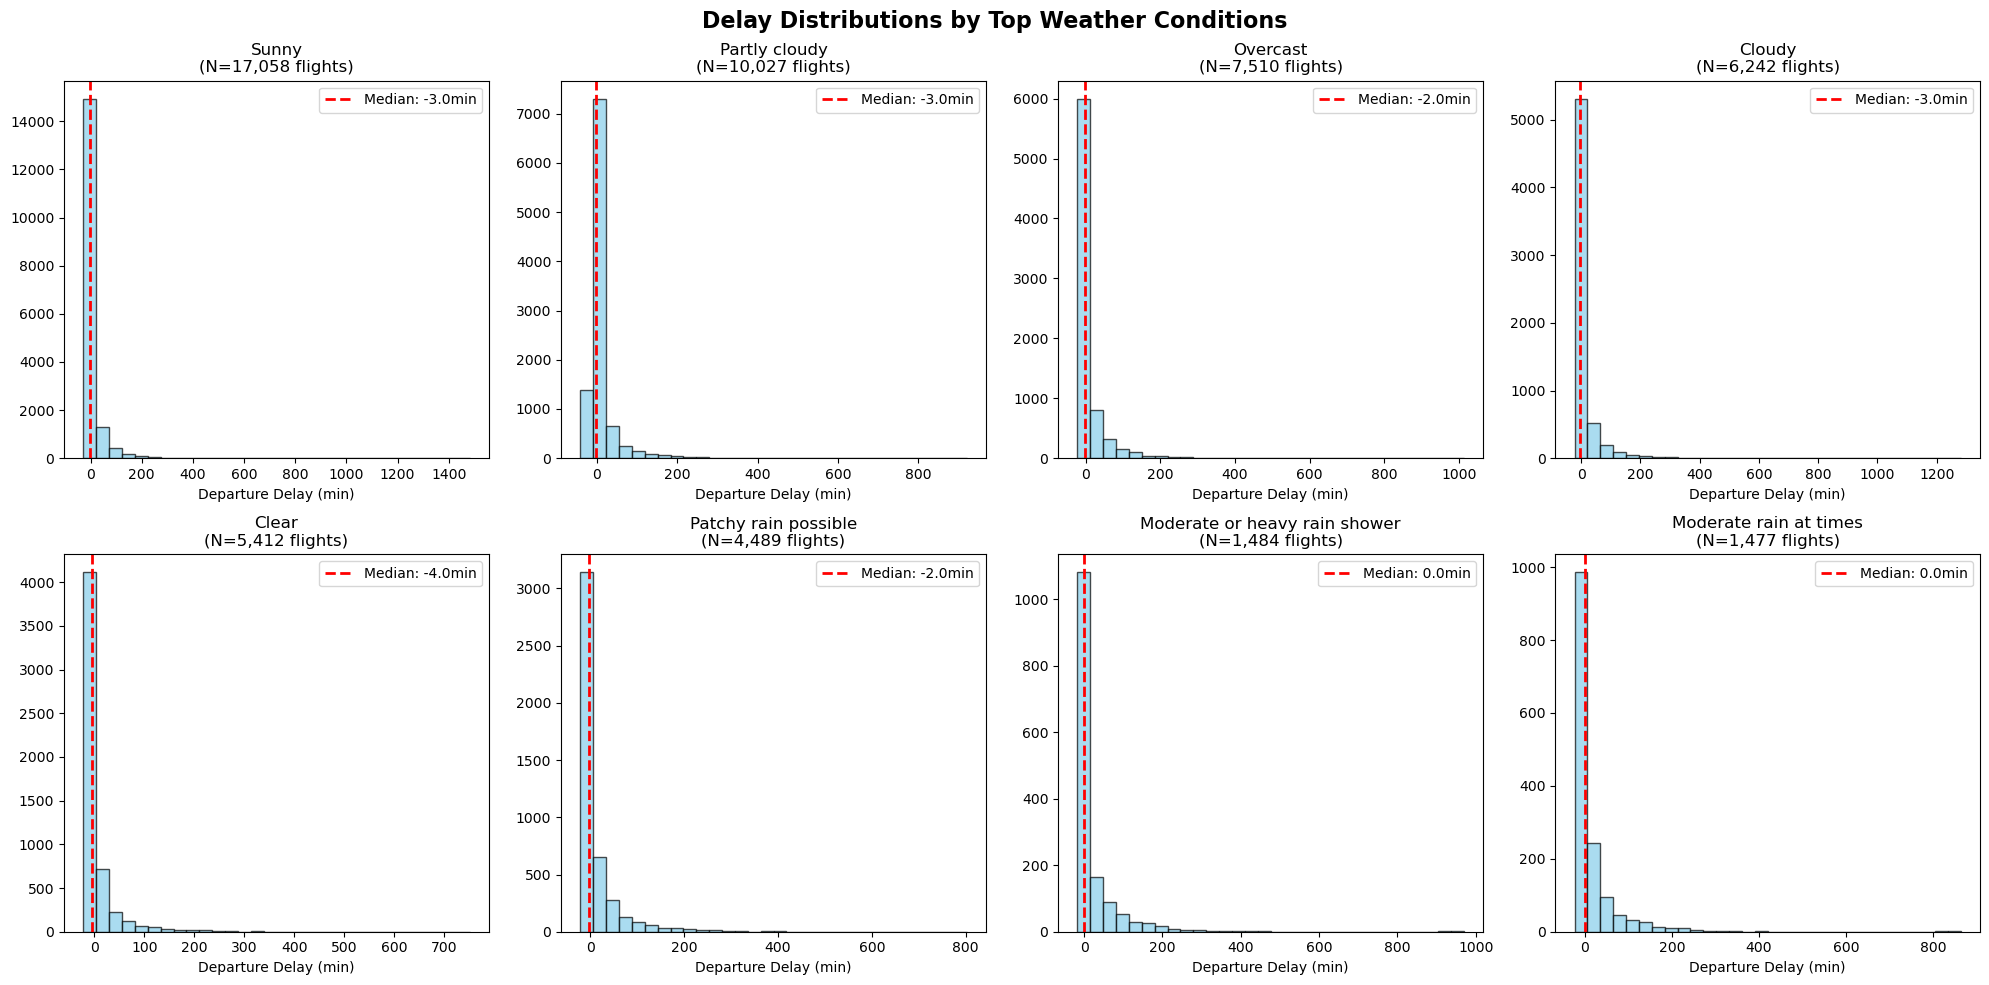

In [47]:
# Weather condition vs delay (proposal requirement)
top_conditions = df['condition_text'].value_counts().head(8).index

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, cond in enumerate(top_conditions):
    subset = df[df['condition_text'] == cond]
    axes[i].hist(subset['DEP_DELAY'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].axvline(subset['DEP_DELAY'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {subset["DEP_DELAY"].median():.1f}min')
    axes[i].set_title(f'{cond}\n(N={len(subset):,} flights)', fontsize=12)
    axes[i].set_xlabel('Departure Delay (min)')
    axes[i].legend()

plt.suptitle('Delay Distributions by Top Weather Conditions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('weather_delay_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


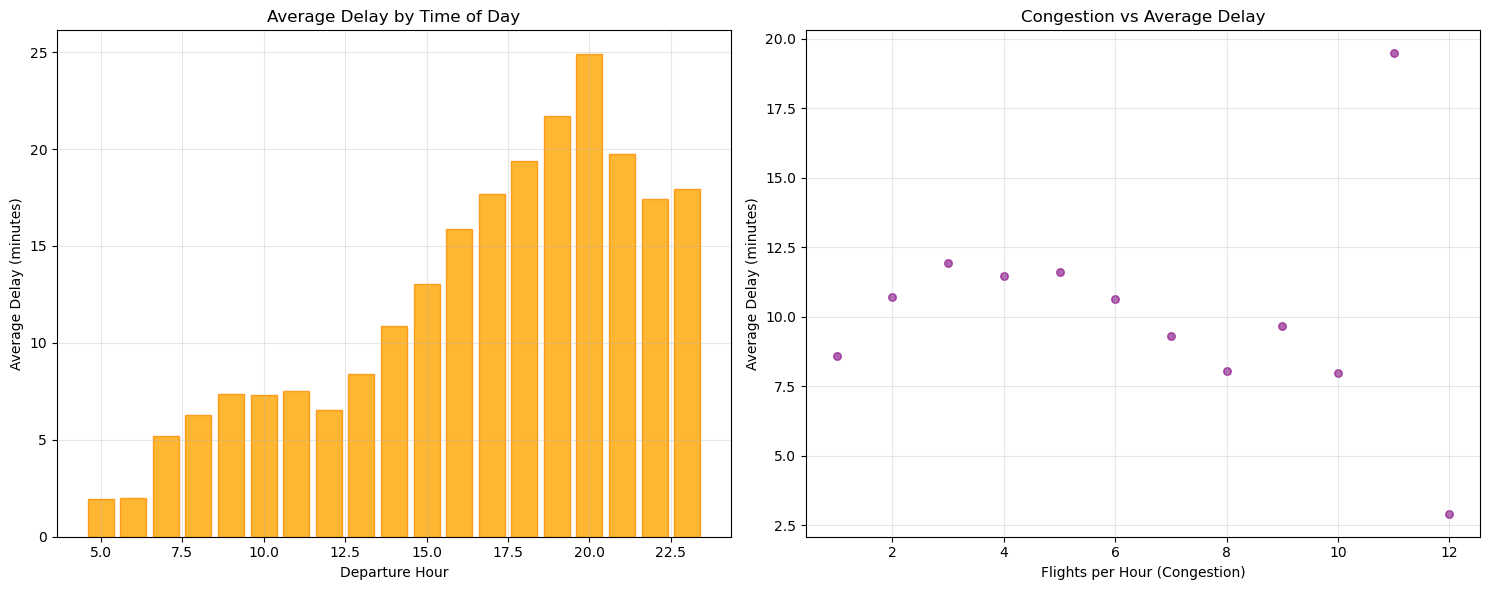

**Key Insight:** Peak congestion hours show -0.106 correlation with delays.


In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Average delay by hour
hourly_delay = df.groupby('DEP_HOUR')['DEP_DELAY'].agg(['mean', 'count']).reset_index()
ax1.bar(hourly_delay['DEP_HOUR'], hourly_delay['mean'], 
        width=0.8, alpha=0.8, color='orange', edgecolor='darkorange')
ax1.set_xlabel('Departure Hour')
ax1.set_ylabel('Average Delay (minutes)')
ax1.set_title('Average Delay by Time of Day')
ax1.grid(alpha=0.3)

# Congestion vs delay
cong_delay = df.groupby('HOURLY_DEP_COUNT')['DEP_DELAY'].mean().reset_index()
ax2.scatter(cong_delay['HOURLY_DEP_COUNT'], cong_delay['DEP_DELAY'], 
            alpha=0.6, s=30, color='purple')
ax2.set_xlabel('Flights per Hour (Congestion)')
ax2.set_ylabel('Average Delay (minutes)')
ax2.set_title('Congestion vs Average Delay')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('temporal_congestion_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("**Key Insight:** Peak congestion hours show", 
      f"{cong_delay['DEP_DELAY'].corr(cong_delay['HOURLY_DEP_COUNT']):.3f}", "correlation with delays.")


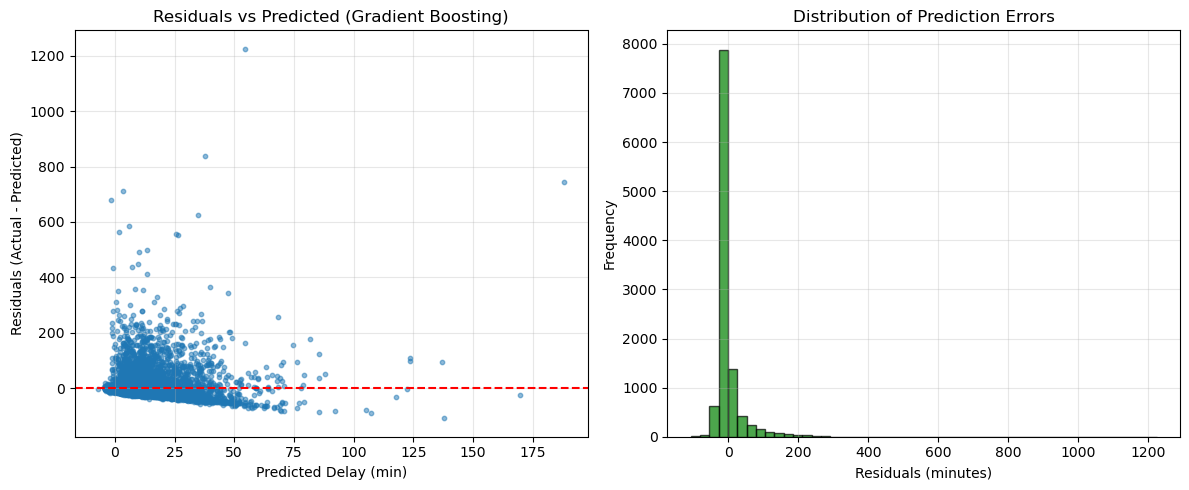

In [49]:
# Residuals plot for best model
y_pred_best = best_reg.predict(X_test)
residuals = y_test - y_pred_best

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_best, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Delay (min)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted (Gradient Boosting)')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Residuals (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()
